# Emotion recognition with RMN
This notebook is for generating saliency maps with the GradCAM method, applied to the RNM (Residual Masking Network) model.

In [1]:
from rmn import *
from img_functions import *
import torch
import pandas as pd
import scipy.stats as stats
from torchsummary import summary
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

c:\Users\terai\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load database

Here we load images. When using BV dataset, images need to be resized to 224x224. When using ET dataset, padding of images needs to be removed then resulting images should be resized to 224x224.

In the datasets used, only four emotions are represented : happiness, sadness, surprise and anger. These emotions are the least ambiguous to classify.

In [2]:
csvBV = ".\\datasets\\BV_labels.csv" # location of BV labels
BVpath = ".\\datasets\\BV" # location of BV images
csvET = ".\\datasets\\ET_labels.csv" # location of ET labels
ETpath = ".\\datasets\\ET" # location of ET images

## Load dataset
imgs, df_labels = load_all(csvBV,BVpath,csvET,ETpath)

## Get labels corresponding to dataset
df_labels.head()

## List relevant emotions
emotions4 = ['happiness','sadness','surprise','anger']

Loaded 200 images successfully
Created dataframe for labels


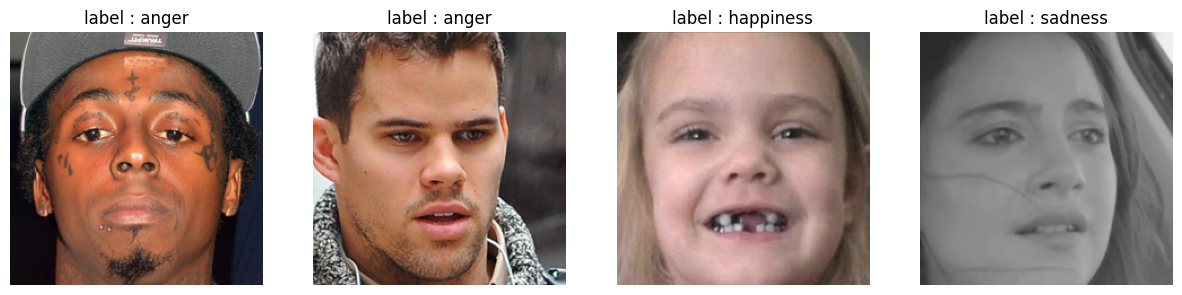

In [3]:
## Display label for four images
plt.figure(figsize=(15,15))
for i in range(4) :
    plt.subplot(1, 4, i + 1)
    im = imgs[i+35]
    label = df_labels['GTEmotion'][i+35]
    plt.title('label : '+label)
    plt.imshow(im)
    plt.axis('off')
plt.show()

## Build facial expression analysis model

The model used here is called RMN (Residual Masking Network). The implementation using PyTorch was provided by the authors on Github : https://github.com/phamquiluan/ResidualMaskingNetwork.

The model consists of four Residual Masking Blocks. Each one of those blocks contains a residual layer followed by a masking block. Each of those masking blocks is similar to a UNet-network, using ResNet34 (ResNet18???) as backbone. The residual layers are used for feature processing, producing feature maps, and the masking blocks help refine these same feature maps.

The emotions predicted are the following : angry, disgust, fear, happy, sad, surprise, neutral.

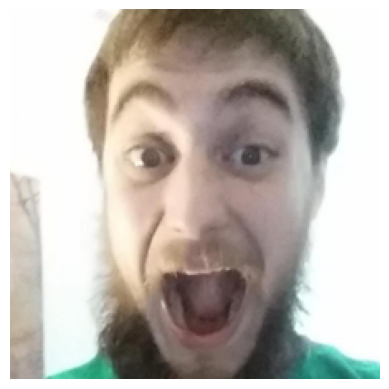

Label: surprise
Emotion predicted: surprise 0.9985852241516113
Outputs: [{'angry': 3.92640104109887e-05}, {'disgust': 9.38075800149818e-07}, {'fear': 0.0010096009355038404}, {'happy': 0.00026209093630313873}, {'sad': 1.614011125639081e-05}, {'surprise': 0.9985852241516113}, {'neutral': 8.667703514220193e-05}]


In [3]:
# Display a single image
im_test = imgs[30]
label_test = df_labels['GTEmotion'][30]
plt.imshow(im_test)
plt.axis('off')
plt.show()

# Display predictions for a single image
# Please note that the detect_emotion_for_single_face_image function resizes the input image
predict = RMN()
emo_label, emo_proba, emo_list = predict.detect_emotion_for_single_face_image(face_image=im_test)
print("Label:",label_test)
print("Emotion predicted:", emo_label, emo_proba)
print("Outputs:",emo_list)

## List predicted emotions
emotions7 = ['happy','sad','surprise','angry','disgust','fear','neutral']

In [4]:
# Build the emotion recognition model
# This is the model of interest in everything that follows
model = get_emo_model()
# Print model architecture
# summary(model,input_size=(3,224,224))
# Print main components
print([n for n, _ in model.named_children()])

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc', 'mask1', 'mask2', 'mask3', 'mask4']


# Apply GradCAM method to generate saliency maps

Here we re-use an existing implementation of GradCAM using PyTorch. Codes can be found on Github : https://github.com/jacobgil/pytorch-grad-cam.

Several CAM methods were implemented by contributors, including GradCAM and GradCAMPlusPlus. Given a deep classification model and an input image, a saliency map can be computed for any selected convolution layer and any selected class.

The selection of the target layer can greatly affect the results obtained in the analysis of the saliency maps. This will be discussed further below in the notebook.

In [5]:
def compute_gradcam(explainer, model, input_img, target_layer, targets) :

    """
    Parameters :
        explainer : choose GradCAM or GradCAMPlusPlus
        model : pre-trained neural network
        input_img : should be PIL image
        target_layer :  convolution layer to compute saliency map for
        targets : target class to compute saliency map for. If target=None, the class with the most important score is selected by default.
    
    Outputs :
        grayscale_cam : gradients (1 channel) display
        visualization : gradients (3 channels) display over original image
    """

    # set transformation parameters
    mean = [0.485, 0.456, 0.406] #[0., 0., 0.]
    std = [0.229, 0.224, 0.225] #[255., 255., 255.]
    normalize_torch = transforms.Normalize(mean,std)
    to_tensor = transforms.ToTensor()
    transform = transforms.Compose([to_tensor,normalize_torch])
    # procede to transformation
    normalized_np = np.float32(input_img) / np.max(input_img)
    # input_tensor = to_tensor(np.array(input_img).copy()).unsqueeze(0)
    input_tensor = to_tensor(normalized_np.copy()).unsqueeze(0)

    match explainer :
        case 'GradCAM':
            with GradCAM(model=model, target_layers=target_layer, use_cuda=True) as cam :
                # computing saliency map
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                # overlay heatmap on original input image
                visualization = show_cam_on_image(img=normalized_np, mask=grayscale_cam, use_rgb=True)
        case 'GradCAMPlusPlus':
            with GradCAMPlusPlus(model=model, target_layers=target_layer, use_cuda=True) as cam :
                # computing saliency map
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                # overlay heatmap on original input image
                visualization = show_cam_on_image(img=normalized_np, mask=grayscale_cam, use_rgb=True)
        case other:
            print('Invalid explainer')

    return grayscale_cam, visualization

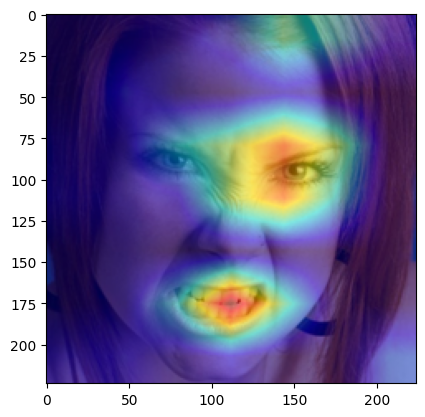

In [7]:
im_test = imgs[14]
target_layers  = [model.layer4[0].conv1]
targets = None
res1, res2 = compute_gradcam('GradCAM',model,im_test,target_layers,targets)
plt.imshow(res2)
plt.show()

In [134]:
# Select target layer and target class
target_layers = [model.layer2[0].conv1,
        model.layer2[0].conv2,
        model.layer2[1].conv1,
        model.layer2[1].conv2,
        model.layer2[2].conv1,
        model.layer2[2].conv2,
        model.layer2[3].conv1,
        model.layer2[3].conv2,
        model.mask3.conv1.conv1,
        model.mask3.conv1.conv2,
        model.layer3[0].conv1,
        model.layer3[0].conv2,
        model.layer3[1].conv1,
        model.layer3[1].conv2,
        model.layer3[2].conv1,
        model.layer3[2].conv2,
        model.mask2.conv1.conv1,
        model.mask2.conv1.conv2,
        model.layer4[0].conv1]
targets = None

# Plot gradcam for nine images
pbindxs = [13, 40, 58, 60, 171, 174]
k = 1
for layer_name in target_layers :
    print(k)
    plt.figure(figsize=(15,15))
    for i in range(len(pbindxs)) :
        plt.subplot(3, 3, i + 1)
        idx = pbindxs[i]
        im = imgs[idx+2]
        label = df_labels['GTEmotion'][idx+2]
        res1, res2 = compute_gradcam('GradCAM', model, im, [layer_name], targets)
        emo_label, emo_proba, proba_list = predict.detect_emotion_for_single_face_image(face_image=im)
        plt.title('Target '+label+'\n Predicted '+emo_label)
        plt.imshow(res2)
    k+=1
    plt.show()

## Display activation maps of target layers

In order to determine which target convolution layers in the RMN model would be most relevant for the computation of the saliency maps, feature maps of selected target layers are visualized.

In [135]:
img=imgs[13]
plt.imshow(img)
plt.axis('off')
plt.show()

# preprocess input data
transform = transforms.ToTensor()
input_tensor = transform(img.copy()).unsqueeze(0)

# create dictionnary to store activations
activation={}
# define hook to record activations of a given layer
def getActivation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# compute feature maps for several convolution layers
i=0
layers=[model.layer3[-1].conv2]

"""model.layer2[0].conv1,
      model.layer2[0].conv2,
      model.layer2[1].conv1,
      model.layer2[1].conv2,
      model.layer2[2].conv1,
      model.layer2[2].conv2,
      model.layer2[3].conv1,
      model.layer2[3].conv2,
      model.mask2.conv1.conv1,
      model.mask2.conv1.conv2,
"""
names=[str(i+1) for i in range(len(layers))]
for l in layers :
    name=names[i]
    i+=1
    # attach hook to the layer
    h=l.register_forward_hook(getActivation(name))
    # pass input tensor to gpu then forward input in the model
    output = model(input_tensor.cuda())
    # print output dimensions of layer
    # print(name,"output dimensions :",activation[name].shape)
    # pass feature map to cpu then display feature map
    k = 0 # choose feature map number k of the layer
    feature_map = activation[name][0][k].cpu()
    ax = plt.imshow(np.array(feature_map), cmap='jet')
    plt.colorbar(ax)
    plt.title(name+" output :"+str(activation[name].shape))
    plt.show()
    # release hook
    h.remove()

# First approach : averaging saliency maps for each emotion

The goal here is to perform a first analysis of the saliency maps generated. The idea is to group images by their prediction then determine, in average, the most active areas for each emotion.

Group_by functions

In [6]:
# Group images by label
def group_by_label(imgs, labels):
    column = "GTExpression"
    list = [],[],[],[]
    for i in range(labels.shape[0]) :
        if (labels[column][i]==1):
            list[0].append(imgs[i]) # add to first list - happiness
        elif (labels[column][i]==2):
            list[1].append(imgs[i]) # add to second list - sadness
        elif (labels[column][i]==3):
            list[2].append(imgs[i]) # add to third list - surprise
        elif (labels[column][i]==6):
            list[3].append(imgs[i]) # add to fourth list - anger  
    return list[0], list[1], list[2], list[3]

def get_distribution(groups):
    list = [len(groups[i]) for i in range(len(groups))]
    return list

# Group images by predicted emotion (model prediction)
def group_by_md_predict(imgs, emotions):
    list = [],[],[],[],[],[],[]
    for i in range(imgs.shape[0]) :
        emo_label, emo_proba, proba_list = predict.detect_emotion_for_single_face_image(face_image=imgs[i])
        for k in range (len(emotions)):
            if (emo_label==emotions[k]) :
                list[k].append(imgs[i])
    return list[0], list[1], list[2], list[3], list[4], list[5], list[6]

# Group images by predicted emotion (human prediction)
def group_by_human_predict(imgs, labels):
    list = [],[],[],[]
    column = "Human_prediction"
    for i in range(labels.shape[0]) :
        if labels[column][i]>0:
            match labels[column][i] :
                case 1 : list[0].append(imgs[i]) # add to first list - happiness
                case 2 : list[1].append(imgs[i]) # add to second list - sadness
                case 3 : list[2].append(imgs[i]) # add to third list - surprise
                case 6 : list[3].append(imgs[i]) # add to fourth list - anger  
    return list[0], list[1], list[2], list[3]

Regrouping images with same emotion label then computing average saliency map for each emotion

Happiness
mean max 0.6929832611485642  min 0.01580919161689111
Sadness
mean max 0.33895542667531925  min 0.050062360485187835
Surprise
mean max 0.41284000710127694  min 0.06035295926895011
Anger
mean max 0.4556386231793392  min 0.0692353751163178


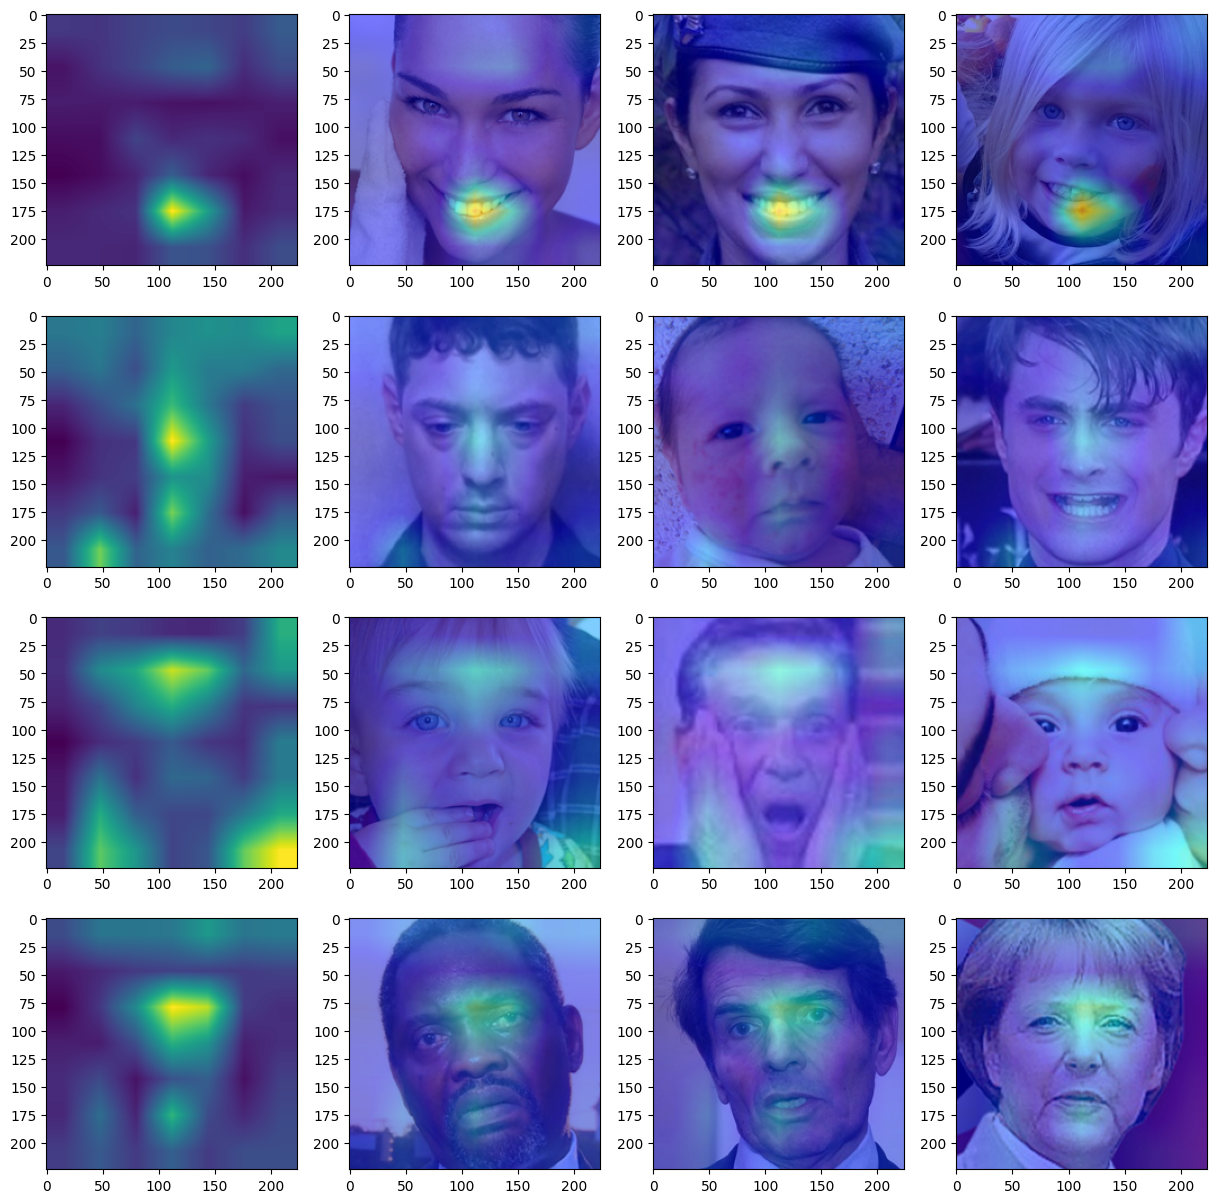

In [137]:
target_layers = [model.layer4[0].conv1]
targets = None

# Separate dataset into four arrays, one array per emotion
emotions = ['Happiness','Sadness','Surprise','Anger']
groups = group_by_label(imgs,df_labels)

fig, ax = plt.subplots(4,4, figsize=(15,15))
for k in range(len(emotions)):

    list_k = groups[k]
    print(emotions[k])

    sum = np.zeros((224,224), dtype=float)
    # Compute gradcam for all images of same emotion
    for im in list_k :
        res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
        sum = sum + res1
    
    # Display averaged saliency
    mean = sum / len(list_k)
    print("mean max",np.max(mean)," min",np.min(mean))
    ax[k,0].imshow(mean)

    # Display averaged saliency over images
    for i in range(3) :
        im_test = list_k[10+i]
        normalized_np = np.float32(im_test) / np.max(im_test)
        show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
        ax[k,i+1].imshow(show_sum_on_image)
plt.show()

Regrouping images with same emotion prediction (RMN) then computing average saliency map for each emotion (happy, sad, surprise and anger only)

43 24 46 44 12 8 23
happy
mean max 0.3731404178905122  min 0.038697302102539036
sad
mean max 0.5445688850983667  min 0.13546800916083157
surprise
mean max 0.5163291593122742  min 0.03470664989689122
angry
mean max 0.3711118675749855  min 0.02543551175089802


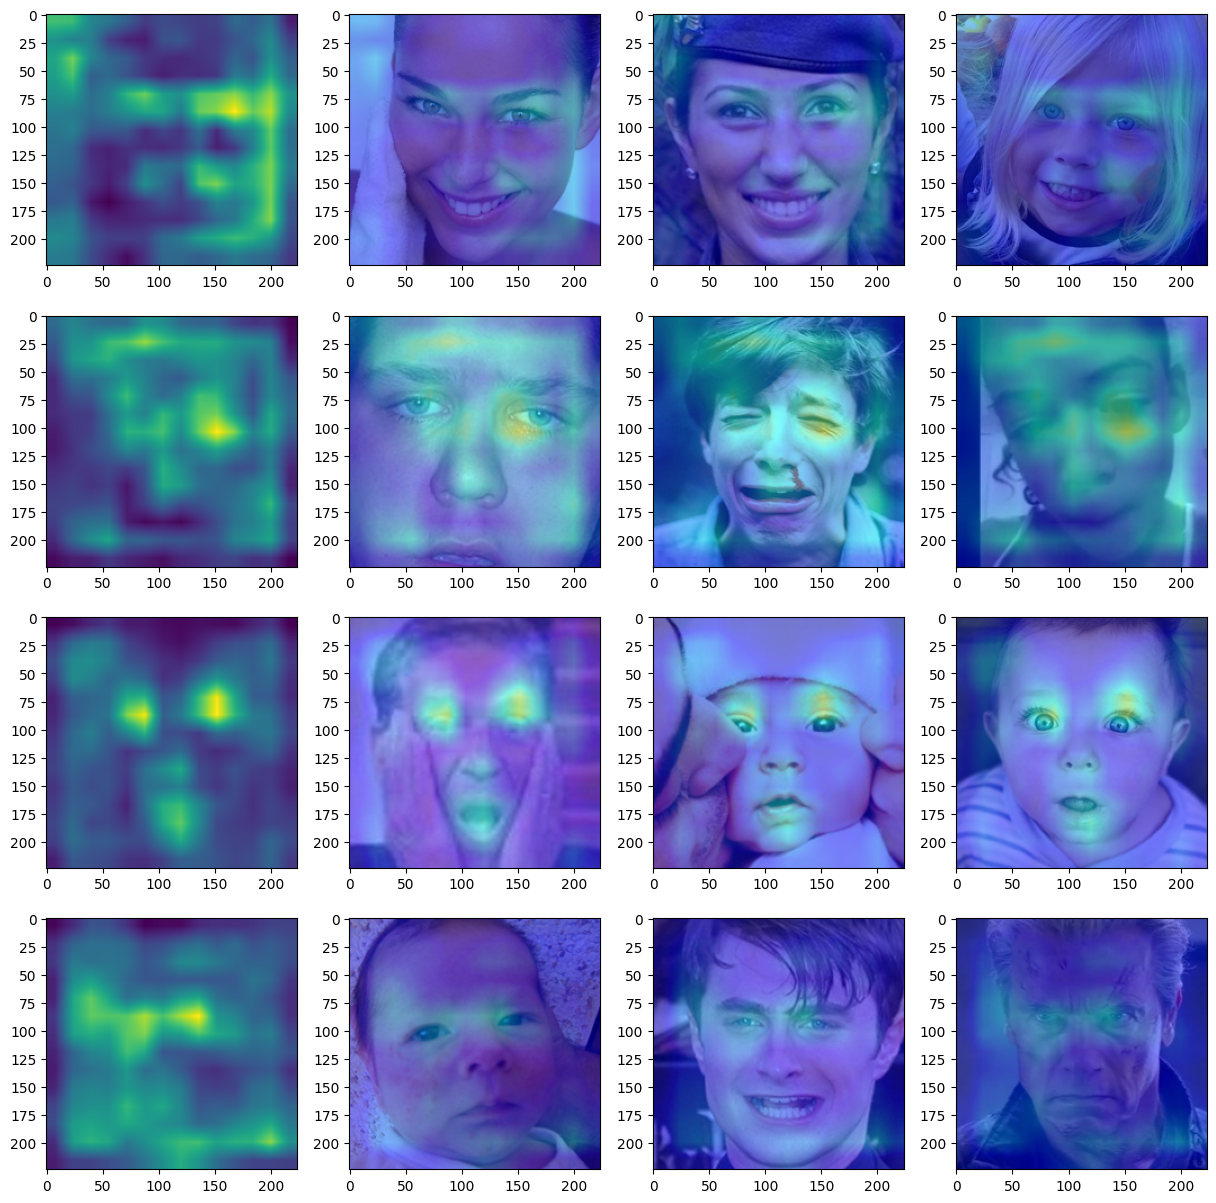

In [12]:
target_layers = [model.layer3[3].conv1]
targets = None

# Separate dataset into four list_ks, one list_k per emotion
emotions = ['happy','sad','surprise','angry','disgust','fear','neutral']
groups = group_by_md_predict(imgs, emotions)
print(len(groups[0]),len(groups[1]),len(groups[2]),len(groups[3]),len(groups[4]),len(groups[5]),len(groups[6]))

fig, ax = plt.subplots(4,4, figsize=(15,15))
for k in range(4):

    list_k = groups[k]
    print(emotions[k])

    sum = np.zeros((224,224), dtype=float)
    # Compute gradcam for all images of same emotion
    for im in list_k :
        res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
        sum = sum + res1
    
    # Display averaged saliency
    mean = sum / len(list_k)
    print("mean max",np.max(mean)," min",np.min(mean))
    ax[k,0].imshow(mean)

    # Display averaged saliency over images
    for i in range(3) :
        im_test = list_k[10+i]
        normalized_np = np.float32(im_test) / np.max(im_test)
        show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
        ax[k,i+1].imshow(show_sum_on_image)
plt.show()

In [14]:
i = 0
# Prediction emotion for each image in the entire dataset
for im in imgs :
    predict = RMN()
    emo_label, emo_proba, proba_list = predict.detect_emotion_for_single_face_image(face_image=im)
    print(emo_label,emo_proba)
    # See where predictions diverge from human evaluation
    if (emo_label!='happy' and df_labels['GTExpression'][i]==1):
        print("img",i+1,"did not predict Happiness")
    elif (emo_label!='sad' and df_labels['GTExpression'][i]==2):
        print("img",i+1,"did not predict Sadness")
    elif (emo_label!='surprise' and df_labels['GTExpression'][i]==3):
        print("img",i+1,"did not predict Surprise")
    elif (emo_label!='angry' and df_labels['GTExpression'][i]==6):
        print("img",i+1,"did not predict Anger")
    i+=1

surprise 0.998206615447998
happy 0.9588839411735535
happy 0.9959241151809692
angry 0.6213281750679016
img 4 did not predict Sadness
surprise 0.9431741833686829
angry 0.9535795450210571
happy 0.46927186846733093
sad 0.9251484870910645
happy 0.7626827359199524
surprise 0.8844372034072876
angry 0.8371792435646057
surprise 0.9465370774269104
angry 0.5812201499938965
fear 0.9611039757728577
img 14 did not predict Sadness
angry 0.5379467606544495
sad 0.9588785171508789
sad 0.7736971378326416
neutral 0.8016411662101746
img 18 did not predict Sadness
disgust 0.5881873369216919
img 19 did not predict Anger
disgust 0.9318215250968933
img 20 did not predict Sadness
happy 0.5848060846328735
happy 0.47421279549598694
surprise 0.9678730368614197
surprise 0.4595649540424347
img 24 did not predict Sadness
surprise 0.9843926429748535
happy 0.9325845241546631
angry 0.9315674304962158
neutral 0.6929437518119812
img 28 did not predict Anger
neutral 0.41081321239471436
img 29 did not predict Sadness
angry 

Compute weighted average saliency map, weights correspond to model's prediction probability (%)

Reminder :
* Model can predict emotions that can range in happy, surprise, sad, angry, disgust, fear and neutral.
* Saliency map is computed for highest scoring class in model prediction.

Computing...
mean max 0.384891544848285  min 0.09374562660398514


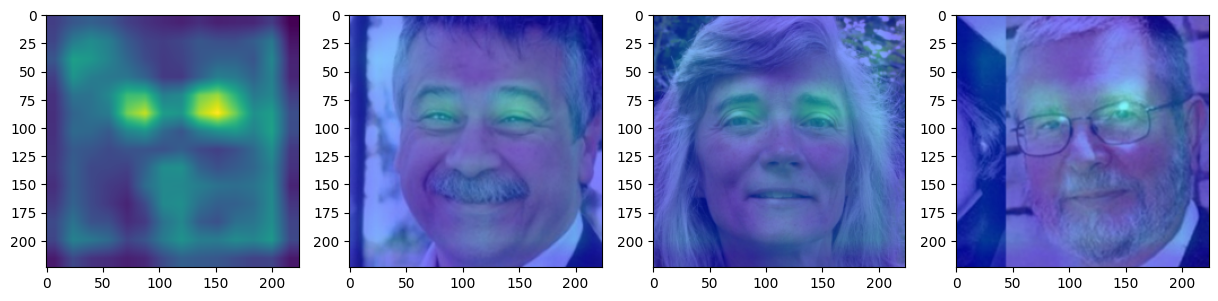

In [58]:
# somme pondérée en fonction de
# modèle : la confiance dans le score prédit (%)

target_layers = [model.layer3[3].conv1]
targets = None

sum = np.zeros((224,224), dtype=float)
sum_proba = 0
i = 0
# Compute weighted gradcam for all images
print("Computing...")
for im in imgs :
    res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
    emo_label, emo_proba, proba_list = predict.detect_emotion_for_single_face_image(face_image=im)
    sum = sum + res1*emo_proba
    sum_proba += emo_proba

# Display averaged saliency
mean = sum / sum_proba
print("mean max",np.max(mean)," min",np.min(mean))
fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(mean)

# Display averaged saliency over images
for i in range(3) :
    im_test = imgs[20+i]
    normalized_np = np.float32(im_test) / np.max(im_test)
    show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
    ax[i+1].imshow(show_sum_on_image)
plt.show()

Compute weighted average saliency map, weights correspond to average human score (%)

Reminder :
* Model can predict emotions that can range in happy, surprise, sad, angry, disgust, fear and neutral.
* Humans picked one of these emotions : Happiness, Surprise, Sadness and Anger
* Saliency map is computed for highest scoring class in model prediction.

mean max 0.33002716548312283  min 0.06288820152112802


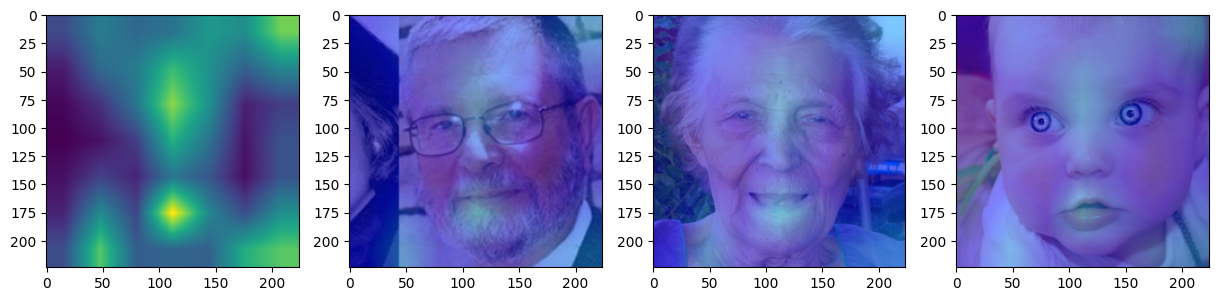

In [11]:
# somme pondérée en fonction de
# humains : pourcentage de votes

target_layers = [model.layer4[0].conv1]
targets = None
dfET = df_labels.loc[(df_labels['Source']=='BV_ET') | (df_labels['Source']=='ET')]
dfET = dfET.reset_index(drop=True)
ETindex = dfET.index
scores = human_scores_for_all(dfET)

sum = np.zeros((224,224), dtype=float)
sum_proba = 0
i = 0
# Compute weighted gradcam for all ET images
for idx in ETindex :
    im = imgs[idx]
    res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
    vote_percent = mean_score(scores[i])
    # print(i+1,vote_percent)
    sum = sum + res1*vote_percent
    sum_proba += vote_percent
    i+=1

# Display averaged saliency
mean = sum / sum_proba
print("mean max",np.max(mean)," min",np.min(mean))
fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(mean)

# Display averaged saliency over images
for i in range(3) :
    im_test = imgs[20+i]
    normalized_np = np.float32(im_test) / np.max(im_test)
    show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
    ax[i+1].imshow(show_sum_on_image)
plt.show()

In [ ]:
# # USING IMGS_FILTERED (ABANDON)
# emotions = ['happy','sad','surprise','angry','disgust','fear','neutral']
# grouped = group_by_md_predict(imgs, emotions)
# imgs_filtered = []
# for k in range(4):
#     array = grouped[k]
#     for im in array :
#         imgs_filtered.append(im)
# imgs_filtered = np.array(imgs_filtered)
# imgs_filtered.shape

# target_layers = [model.layer3[-1].conv2]
# targets = None
# scores = human_scores_for_all(df_labels)

# sum = np.zeros((224,224), dtype=float)
# sum_proba = 0
# i = 0
# # Compute weighted gradcam for all images
# for im in imgs :
#     res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
#     emo_label, emo_proba, proba_list = predict.detect_emotion_for_single_face_image(face_image=im)
#     if ((emo_label=='happy' and df_labels['GTEmotion'][i]=='Happiness')
#         or (emo_label=='sad' and df_labels['GTEmotion'][i]=='Sadness')
#         or (emo_label=='surprise' and df_labels['GTEmotion'][i]=='Surprise')
#         or (emo_label=='angry' and df_labels['GTEmotion'][i]=='Anger')):
#             vote_percent = mean_score(scores[i],49)
#             print(i+1,vote_percent)
#             sum = sum + res1*vote_percent
#             sum_proba += vote_percent
#     i+=1

# # Display averaged saliency
# mean = sum / sum_proba
# print("mean max",np.max(mean)," min",np.min(mean))
# fig, ax = plt.subplots(1,4, figsize=(15,15))
# ax[0].imshow(mean)

# # Display averaged saliency over images
# for i in range(3) :
#     im_test = imgs[20+i]
#     normalized_np = np.float32(im_test) / np.max(im_test)
#     show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
#     ax[i+1].imshow(show_sum_on_image)
# plt.show()

# Second approach : evaluating similarities between images and visualizing patterns in 2D space

We use Pearson correlation to evaluate the similarities in every possible pair of images. We test diverse criterion to group images, then apply Pearson correlation to these groups. The goal is to try and bring out patterns when visualizing the images in a 2D space.

Generate saliency map of all images and store each map

In [7]:
def storemaps(arr, target_layers, targets):
    maps = []
    for i in range(arr.shape[0]) :
        im = arr[i]
        res1, _ = compute_gradcam('GradCAM', model, im, target_layers, targets)
        maps.append(res1)
        # find images for which all gradients are negative, resulting in only 0 in saliency map
        account = 1
        for j in range(res1.shape[0]):
            for k in range(res1.shape[0]):
                if (res1[j][k]!=0.):
                    account = 0
        if account:
            print("error img",i)
            plt.imshow(im)
            plt.axis('off')
            plt.show()
    maps = np.array(maps)
    return maps

Compute matrix containing Pearson correlation between all images (in pairs)

In [8]:
# Compute correlation coefficients for all pairs of images
def pearsonV0(maps):
    m = np.zeros((maps.shape[0],maps.shape[0]), dtype=float)
    # mr = m
    for i in range(maps.shape[0]):
        for j in range(maps.shape[0]):
            x = maps[i,:,:]
            y = maps[j,:,:]
            coefs_1 = np.corrcoef(x.flatten(),y.flatten())
            m[i][j] = coefs_1[0,1]
            # xr = np.array(res1[i])[:,:,0]
            # yr = np.array(res1[j])[:,:,0]
            # coefs_2r = np.corrcoef(xr.flatten(),yr.flatten())
            # mr[i][j] = coefs_2r[0,1]
    return m

def pearson2(maps,groups):
    mat = np.zeros((maps.shape[0],maps.shape[0]), dtype=float)
    # compute coefficients
    for i in range(maps.shape[0]):
        for j in range(maps.shape[0]):
            x = maps[i,:,:]
            y = maps[j,:,:]
            coefs = np.corrcoef(x.flatten(),y.flatten())
            mat[i][j] = coefs[0,1]
    # divide matrix into smaller bits
    nb_emo = len(groups)
    submats_sizes = np.array(get_distribution(groups))
    fullsubmats = []
    for m in range(nb_emo):
        for n in range(nb_emo):
            offsetmat_m = np.sum(submats_sizes[:m])
            offsetmat_n = np.sum(submats_sizes[:n])
            total_m = submats_sizes[m]
            total_n = submats_sizes[n]
            submat = mat[offsetmat_m:offsetmat_m+total_m,offsetmat_n:offsetmat_n+total_n]
            # print(m,n,submat.shape)
            # print(offsetmat_m,total_m,offsetmat_n,total_n)
            fullsubmats.append(submat)
    fullsubmats = np.array(fullsubmats).reshape((nb_emo,nb_emo))
    return fullsubmats

def pearsonV2(maps,groups):
    m = np.zeros((maps.shape[0],maps.shape[0]), dtype=float)
    for i in range(maps.shape[0]):
        for j in range(maps.shape[0]):
            x = maps[i,:,:]
            y = maps[j,:,:]
            coefs = np.corrcoef(x.flatten(),y.flatten())
            m[i][j] = coefs[0,1]
    sizes = get_distribution(groups)
    for k in range(len(groups)):
        idx = int(np.sum(sizes[:k]))
        # insert column
        m = np.insert(m,[idx],'NaN',axis=1)
        # insert row
        m = np.insert(m,[idx],[['NaN']],axis=0)
    return m

## Generating maps for images

error img 24


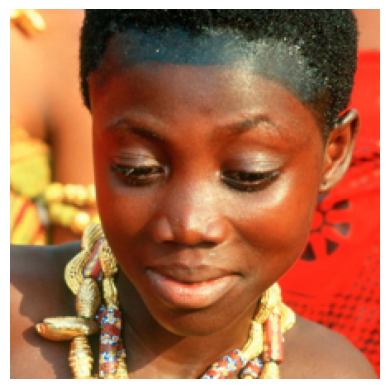

error img 60


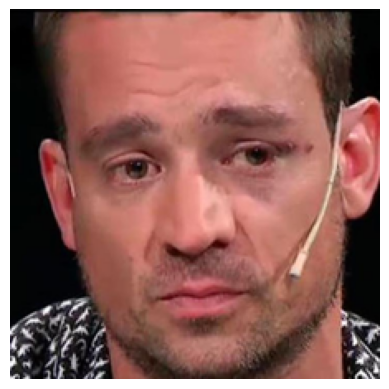

error img 83


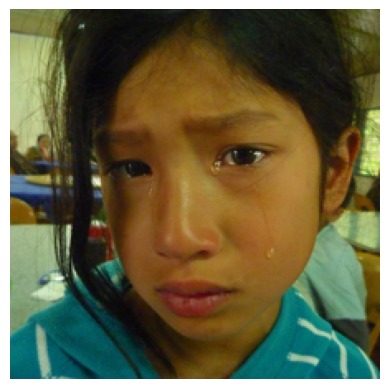

error img 86


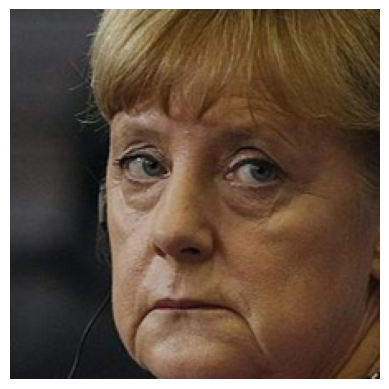

(200, 224, 224)
error img 43


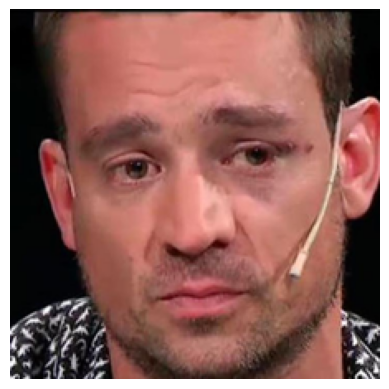

error img 113


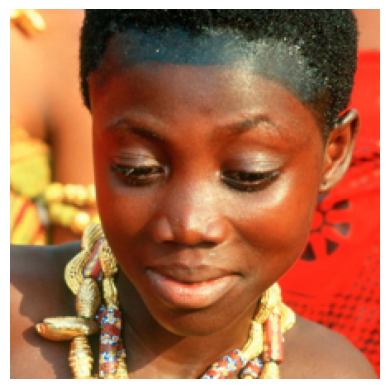

(120, 224, 224)


In [12]:
# Choose target layers and target emotions for computation of saliency maps
target_layers = [model.layer3[-1].conv2]
targets = None

# Sort images by emotion label
groups = group_by_label(imgs,df_labels)
imgs_by_label = []
# Images are then stored in a new array
for k in range(4):
    for im in groups[k]:
        imgs_by_label.append(im)
imgs_by_label = np.array(imgs_by_label)

# # Sort ET images by human prediction
groups = group_by_label(imgs,dfET)
imgsET_by_label = []
# images are then stored in a new array
for k in range(len(groups)):
    for im in groups[k]:
        imgsET_by_label.append(im)
imgsET_by_label = np.array(imgsET_by_label)

# Store saliency maps for each array considered
# mapsV1 = storemaps(imgs, target_layers, targets)
# print(mapsV1.shape)
mapsV2 = storemaps(imgs_by_label, target_layers, targets)
print(mapsV2.shape)
mapsV3 = storemaps(imgsET_by_label, target_layers, targets)
print(mapsV3.shape)

In [13]:
dfET = dfET.assign(Human_prediction=-1)

# sort images according to threshold voting score
threshold = 90.0 # i.e at least 45 participants must agree
for i in range(scores.shape[0]):
    avg = mean_score(scores[i])
    if avg>=threshold:
        max_idx = np.argmax(scores[i])+1
        match max_idx:
            case 1 : highest_class = 1 # happiness
            case 2 : highest_class = 2 # sadness
            case 3 : highest_class = 3 # surprise
            case 4 : highest_class = 6 # anger
        dfET.loc[i,'Human_prediction'] = highest_class

# Sort images based on participants' votes
dfETabove = dfET.loc[dfET['Human_prediction']>0]
dfETabove = dfETabove.reset_index(drop='True')
groups = group_by_human_predict(imgs,dfETabove)
print(len(groups[0]),len(groups[1]),len(groups[2]),len(groups[3]))
# Grouped images are then stored in a single array
imgsA = []
for k in range(4):
    for im in groups[k]:
        imgsA.append(im)
imgsA = np.array(imgsA)

# Storing saliency maps
target_layers = [model.layer3[-1].conv2]
targets = None
mapsV4 = storemaps(imgsA, target_layers, targets)
print(mapsV4.shape)

23 13 13 5
(54, 224, 224)


c:\Users\terai\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\terai\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


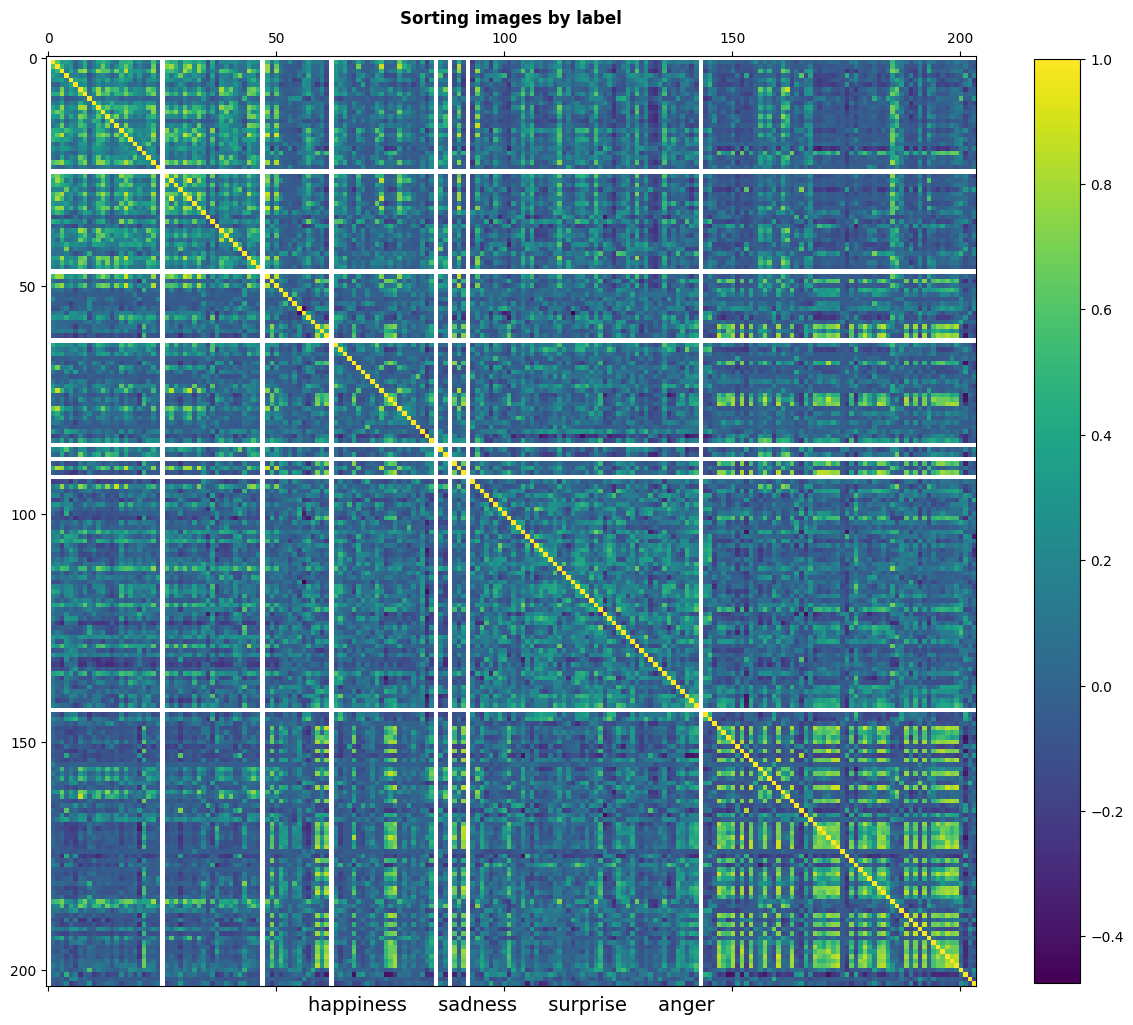

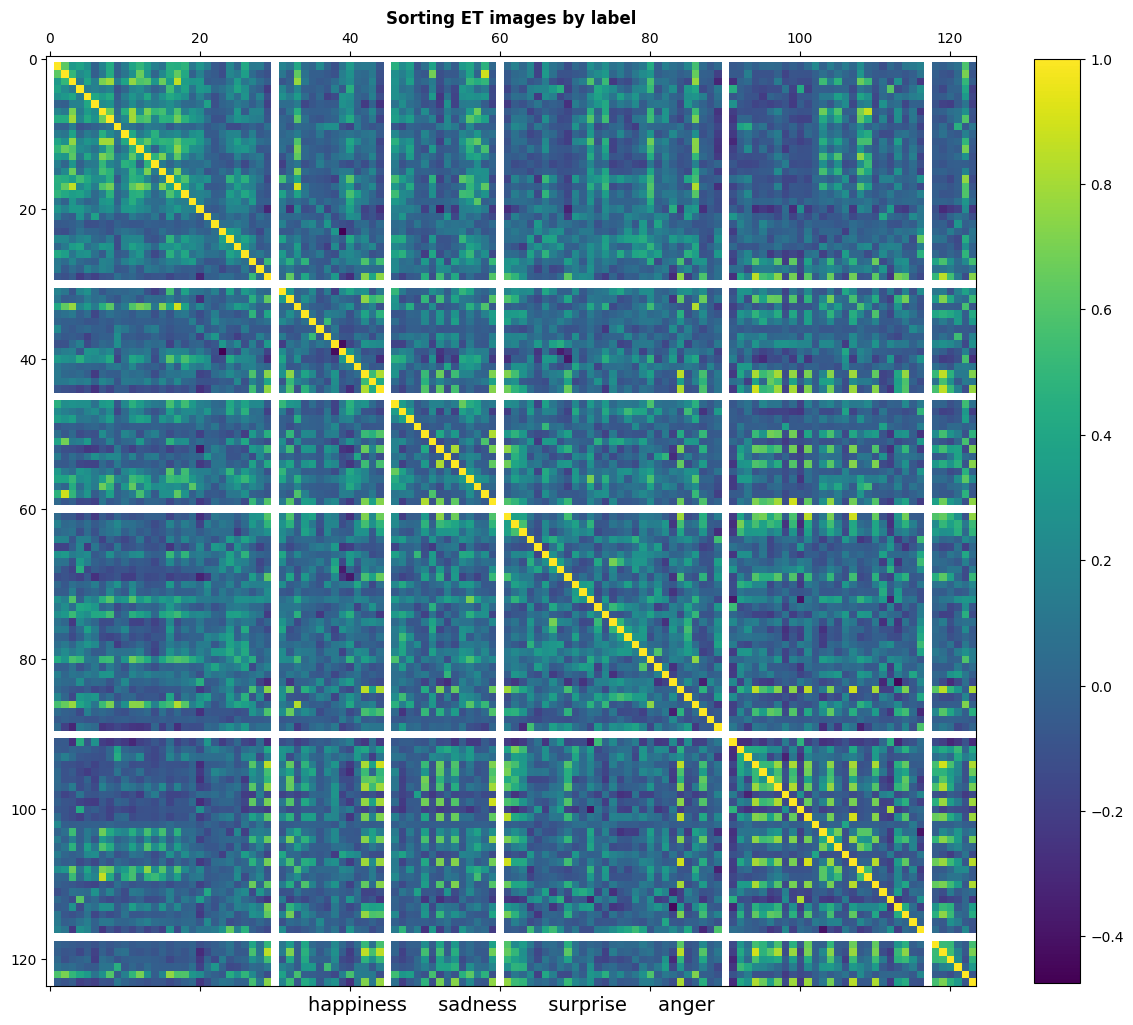

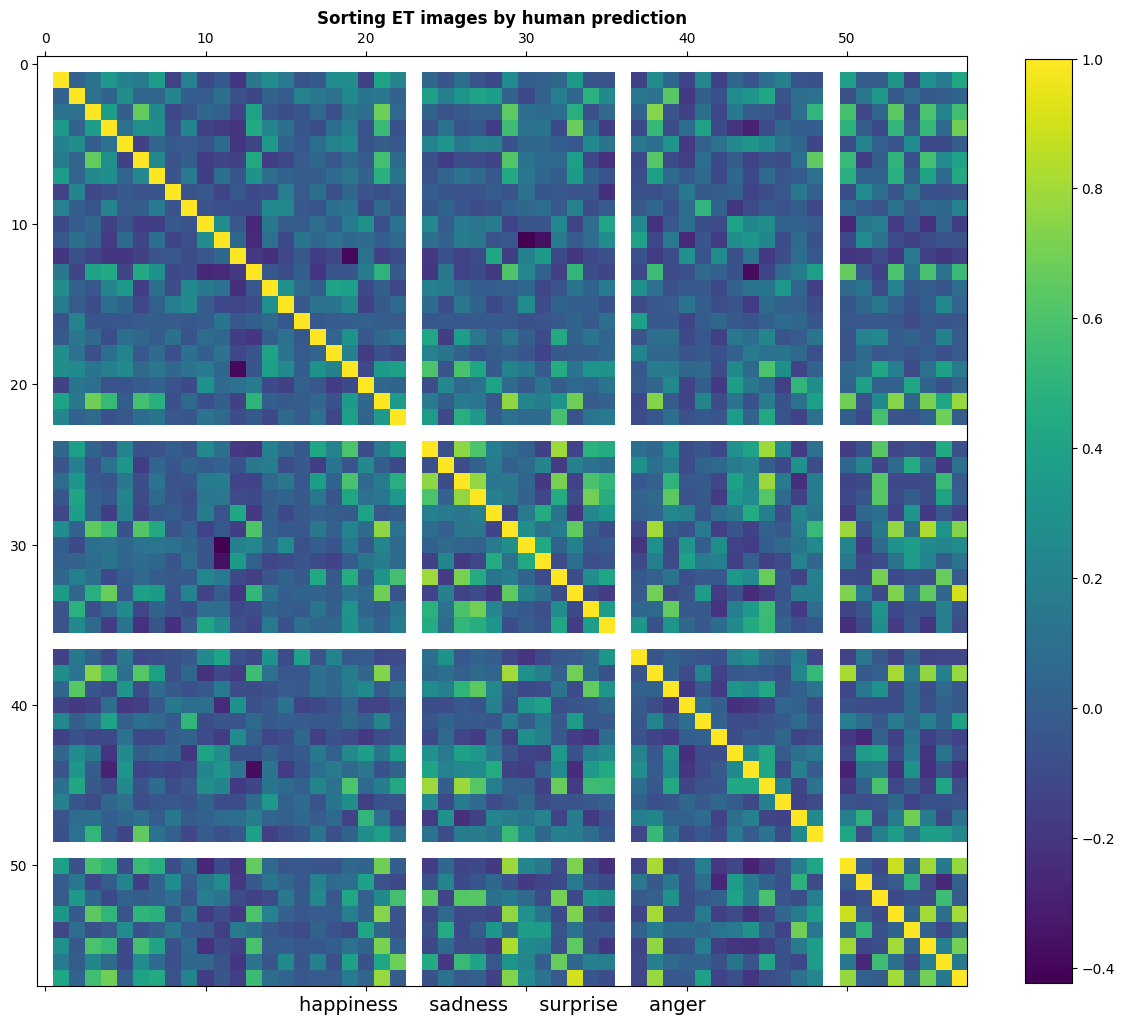

In [14]:
groups = group_by_label(imgs,df_labels)
m = pearsonV2(mapsV2,groups)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sorting images by label', fontweight='semibold')
ax.set_xlabel('happiness     sadness     surprise     anger', fontsize=14)
im = ax.matshow(m)
plt.colorbar(im, ax=ax, shrink=0.8)

groups = group_by_label(imgs,dfET)
m = pearsonV2(mapsV3,groups)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sorting ET images by label', fontweight='semibold')
ax.set_xlabel('happiness     sadness     surprise     anger', fontsize=14)
im = ax.matshow(m)
plt.colorbar(im, ax=ax, shrink=0.8)

groups = group_by_human_predict(imgs,dfETabove)
m = pearsonV2(mapsV4,groups)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sorting ET images by human prediction', fontweight='semibold')
ax.set_xlabel('happiness     sadness     surprise     anger', fontsize=14)
im = ax.matshow(m)
plt.colorbar(im, ax=ax, shrink=0.8)

In [56]:
# pd.set_option('display.max_rows', df.shape[0]+1)
# df

## Plotting all matrixes

In [23]:
layer_name = 'layer3[3].conv1'

# Compute matrixes of Pearson coefficients
# groups = group_by_label(imgs,df_labels)
# # m1 = pearsonV0(mapsV1)
# m2 = pearson2(mapsV2,groups)
# m3 = pearsonV0(mapsV3)
emotions = ['happiness','sadness','surprise','anger']
groups_predA = group_by_label(imgs_by_predA,dfETabove)
groups_predB = group_by_label(imgs_by_predB,dfETbelow)
# m4 = pearson4(mapsV4,imgs_above_thresh)
# m5 = pearson4(mapsV5,imgs_below_thresh)
m6 = pearson4(mapsV6,imgs_by_predA,groups_predA)
m7 = pearson4(mapsV7,imgs_by_predB,groups_predB)

# Plot matrixes
# hot colors->positive correlation
# yellow->correlation equal to 1.0
# cold colors->negative
# fig1, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,20))
# ax1.set_title('No sorting')
# ax1.matshow(m1)

# ax2.set_title('Sorted by label')
# ax2.set_xlabel('happiness  sadness  surprise  anger')
# ax2.set_ylabel('happiness  sadness  surprise  anger')
# ax2.matshow(m2)

# emotions = ['happiness','sadness','surprise','anger']
# fig, axes = plt.subplots(4,4,sharex=False, sharey=False,figsize=(10,10))
# fig.set_title('Pearson correlation between maps \n (maps sorted by ET label) \n layer'+layer_name)
# for i, row in enumerate(axes):
#     for j, cell in enumerate(row):
#         im = cell.matshow(m[i][j])
#         plt.colorbar(im, ax=cell, shrink=0.7)
#         if i == len(axes) - 1:
#             cell.set_xlabel(emotions[j], fontweight='semibold')
#         if j == 0:
#             cell.set_ylabel(emotions[i], fontweight='semibold')
# plt.tight_layout()

# axes[0,0].set_title(emotions[0])
# axes[1,0].set_title(emotions[1])
# axes[2,0].set_title(emotions[2])
# axes[3,0].set_title(emotions[3])
# axes[0,0].set_title(emotions[0])
# axes[0,0].set_title(emotions[0])
# axes[0,0].set_title(emotions[0])
# axes[0,0].set_title(emotions[0])

# fig.supylabel('happiness  sadness  surprise  anger')

# ax3.set_title('Sorted by prediction')
# ax3.set_xlabel('happy  sad  surprise  angry  disgust  fear  neutral')
# ax3.set_ylabel('happy  sad  surprise  angry  disgust  fear  neutral')
# ax3.matshow(m3)
fig2, (ax6,ax7) = plt.subplots(1, 2, figsize=(30,30))
# ax4.set_title('ET : Above thresh 80 - sorted by label')
# ax4.set_xlabel('happiness  sadness  surprise  anger')
# ax4.set_ylabel('happiness  sadness  surprise  anger')
# ax4.matshow(m4)
# ax5.set_title('ET : Below thresh 80 - sorted by label')
# ax5.set_xlabel('happiness  sadness  surprise  anger')
# ax5.set_ylabel('happiness  sadness  surprise  anger')
# ax5.matshow(m5)
# ax6.set_title('ET : Above thresh 80 - sorted by prediction')
# ax6.set_xlabel('happy  sad  surprise  angry  disgust  fear  neutral')
# ax6.set_ylabel('happy  sad  surprise  angry  disgust  fear  neutral')
ax6.matshow(m6)
# ax7.set_title('ET : Below thresh 80 - sorted by label')
# ax7.set_xlabel('happy  sad  surprise  angry  disgust  fear  neutral')
# ax7.set_ylabel('happy  sad  surprise  angry  disgust  fear  neutral')
ax7.matshow(m7)

IndexError: index 68 is out of bounds for axis 0 with size 68

In [ ]:
# To do :
# - 6 weird images
# 1° matrice pearson avec predictions des humains
# 2° ponctuer par degré d'agrément entre les participants
# -> matrice pearson : 1 pour ceux dont le degré est au-dessus d'un seuil, 1 en-dessous
# paramètre manual_auto à voir

Compute similarities between all images using t-sne algorithm